In [1]:
%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)

2.2.0-rc4


In [2]:
# Download the dataset
!git clone https://github.com/AlessioGalluccio/GuyaDataSet

Cloning into 'GuyaDataSet'...
remote: Enumerating objects: 227, done.
remote: Counting objects: 100% (227/227), done.
remote: Compressing objects: 100% (219/219), done.
remote: Total 227 (delta 12), reused 216 (delta 4), pack-reused 0
Receiving objects: 100% (227/227), 39.50 MiB | 32.26 MiB/s, done.
Resolving deltas: 100% (12/12), done.


In [3]:
!git clone https://github.com/AlessioGalluccio/GANguya
!unzip /content/GANguya/Miko_minimal.zip

Cloning into 'GANguya'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 9 (delta 1), reused 5 (delta 0), pack-reused 0
Unpacking objects: 100% (9/9), done.
Archive:  /content/GANguya/Miko_minimal.zip
  inflating: Miko_Minimal/Miko0.png  
  inflating: Miko_Minimal/Miko1.png  
 extracting: Miko_Minimal/Miko10.png  
 extracting: Miko_Minimal/Miko100.png  
  inflating: Miko_Minimal/Miko101.png  
  inflating: Miko_Minimal/Miko102.png  
  inflating: Miko_Minimal/Miko103.png  
 extracting: Miko_Minimal/Miko104.png  
  inflating: Miko_Minimal/Miko105.png  
  inflating: Miko_Minimal/Miko106.png  
 extracting: Miko_Minimal/Miko107.png  
 extracting: Miko_Minimal/Miko108.png  
  inflating: Miko_Minimal/Miko109.png  
  inflating: Miko_Minimal/Miko11.png  
 extracting: Miko_Minimal/Miko110.png  
  inflating: Miko_Minimal/Miko111.png  
  inflating: Miko_Minimal/Miko112.png  
  inflating: Miko_Minimal/Mik

In [4]:
!mkdir training
%cd training
!mkdir Kaguya
!mkdir Miko
%cd ..
!mkdir validation
%cd validation
!mkdir Kaguya
!mkdir Miko
%cd ..

/content/training
/content
/content/validation
/content


In [0]:
import os
import shutil

#copy bakaguya images training in training/Kaguya
path_bakaguya = 'GuyaDataSet/training/bakaguya'
bakaguya_images = sorted(os.listdir(path_bakaguya))
for image in bakaguya_images:
  shutil.copyfile(os.path.join(path_bakaguya, image), os.path.join('training/Kaguya', image))

#copy iceguya images training in training/Kaguya
path_iceguya = 'GuyaDataSet/training/iceguya'
iceguya_images = sorted(os.listdir(path_iceguya))
for image in iceguya_images:
  shutil.copyfile(os.path.join(path_iceguya, image), os.path.join('training/Kaguya', image))

In [0]:
def copyImagesFromDirToDir(path_source, path_dest, add_character_prefix = ''):
  images = sorted(os.listdir(path_source))
  for image in images:
    shutil.copyfile(os.path.join(path_source, image), os.path.join(path_dest, add_character_prefix + image))

In [0]:
#copy bakaguya validation in training/Kaguya
copyImagesFromDirToDir('GuyaDataSet/validation/bakaguya', 'training/Kaguya', 'V')
#copy iceguya validation in training/Kaguya
copyImagesFromDirToDir('GuyaDataSet/validation/iceguya', 'training/Kaguya', 'V')
#copy Miko images in training/Miko
copyImagesFromDirToDir('Miko_Minimal', 'training/Miko')

# ImageGenerator

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt

SEED = 42

train_path = '/content/training'
validation_path = '/content/validation'

bs = 16
image_size = 224
num_class = len(os.listdir(train_path))

lista = os.listdir(train_path)
lista.sort()

image_datagen = ImageDataGenerator(rescale=1./255,
                                     validation_split=0.2)


train_generator = image_datagen.flow_from_directory(
                        directory= train_path,
                        subset= 'training',
                        target_size=(image_size,image_size),
                        batch_size=bs,
                        classes = lista,
                        color_mode='rgb',
                        shuffle=True,
                        class_mode='binary',
                        seed = SEED)

validation_generator = image_datagen.flow_from_directory(
                        directory= train_path,
                        subset= 'validation',
                        target_size=(image_size,image_size),
                        batch_size=bs,
                        save_to_dir= validation_path, #TODO doesn't work
                        classes = lista,
                        color_mode='rgb',
                        shuffle=True,
                        class_mode='binary',
                        seed = SEED)

Found 213 images belonging to 2 classes.
Found 52 images belonging to 2 classes.


In [0]:
train_dataset = tf.data.Dataset.from_generator(lambda: train_gen,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, image_size, image_size, 3], [None, num_class]))
train_dataset = train_dataset.repeat()

valid_dataset = tf.data.Dataset.from_generator(lambda: valid_gen, 
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, image_size, image_size, 3], [None, num_class]))

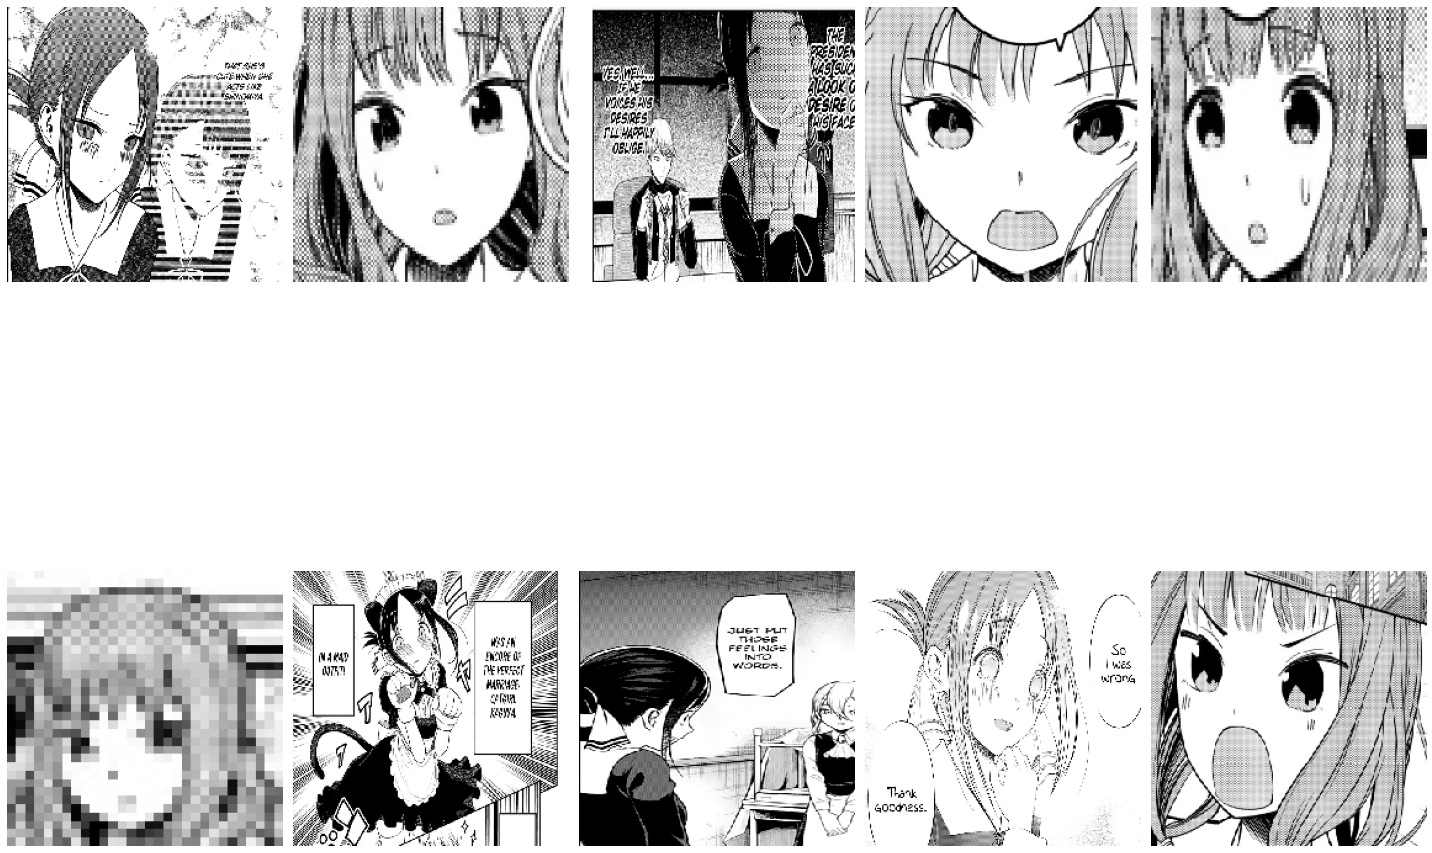

In [10]:
import matplotlib.pyplot as plt

sample_training_images, _ = next(train_generator)

# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(2, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

plotImages(sample_training_images[:10])

In [11]:
train_generator.class_indices

{'Kaguya': 0, 'Miko': 1}

# Model

In [0]:
import tensorflow.keras.layers as layers

model = tf.keras.models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(image_size, image_size, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(1, activation='sigmoid'))

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 64)        36928     
_________________________________________________________________
flatten (Flatten)            (None, 173056)            0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1

In [0]:
# Optimization params
# -------------------

# Loss
loss = tf.keras.losses.BinaryCrossentropy()

# learning rate
lr = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
# -------------------

# Validation metrics
# ------------------

metrics = ['accuracy']
# ------------------

# Compile Model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [15]:
train_generator.samples

213

In [16]:
import os
from datetime import datetime

# from tensorflow.compat.v1 import ConfigProto
# from tensorflow.compat.v1 import InteractiveSession

# config = ConfigProto()
# config.gpu_options.allow_growth = True
# session = InteractiveSession(config=config)

cwd = os.getcwd()

exps_dir = os.path.join(cwd, 'classification_experiments')
if not os.path.exists(exps_dir):
    os.makedirs(exps_dir)

now = datetime.now().strftime('%b%d_%H-%M-%S')

model_name = 'CNN'

exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)
    
callbacks = []

# Model checkpoint
# ----------------
ckpt_dir = os.path.join(exp_dir, 'ckpts')
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp_{epoch:02d}.ckpt'), 
                                                   save_weights_only=True)  # False to save the model directly
callbacks.append(ckpt_callback)

# Visualize Learning on Tensorboard
# ---------------------------------
tb_dir = os.path.join(exp_dir, 'tb_logs')
if not os.path.exists(tb_dir):
    os.makedirs(tb_dir)
    
# By default shows losses and metrics for both training and validation
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                             profile_batch=0,
                                             histogram_freq=1)  # if 1 shows weights histograms
callbacks.append(tb_callback)

# Early Stopping
# --------------
early_stop = True
if early_stop:
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=0, restore_best_weights=True)
    callbacks.append(es_callback)

model.fit(x=train_generator,
          epochs=30,  #### set repeat in training dataset
          steps_per_epoch=int(np.ceil(len(train_generator))),
          validation_data=validation_generator,
          validation_steps=int(np.ceil(len(validation_generator))),
          callbacks=callbacks)

Epoch 1/30
14/14 [==============================] - 2s 130ms/step - loss: 0.7764 - accuracy: 0.7042 - val_loss: 0.2718 - val_accuracy: 0.9808
Epoch 2/30
14/14 [==============================] - 2s 112ms/step - loss: 0.2368 - accuracy: 0.9249 - val_loss: 0.6080 - val_accuracy: 0.8462


In [0]:
model.save('GuyaClassificator.h5') 

In [18]:
#voglio vedere le predizioni sul validation set
test_datagen = ImageDataGenerator(rescale=1./255)



test_generator = test_datagen.flow_from_directory(directory='validation',
                              # only read images from `test` directory
                              # don't generate labels
                              classes=['iceguya'],
                              class_mode=None,
                              # don't shuffle
                              shuffle=False,
                              # use same size as in training
                              target_size=(image_size, image_size))


pred = model.predict(x=train_generator,
              callbacks = callbacks,
              steps = len(train_generator),
              verbose = 1)
pred

Found 0 images belonging to 1 classes.
14/14 [==============================] - 1s 55ms/step


array([[0.80817145],
       [0.75397784],
       [0.01161959],
       [0.0288044 ],
       [0.7541398 ],
       [0.46485925],
       [0.14024425],
       [0.82402754],
       [0.00623029],
       [0.7809112 ],
       [0.7193922 ],
       [0.8025715 ],
       [0.8287783 ],
       [0.80638766],
       [0.26641768],
       [0.03734359],
       [0.02926236],
       [0.77262545],
       [0.10800187],
       [0.7901777 ],
       [0.0665855 ],
       [0.78543156],
       [0.06744093],
       [0.03014703],
       [0.06170535],
       [0.8457061 ],
       [0.73486656],
       [0.8176484 ],
       [0.00680554],
       [0.79544735],
       [0.78841585],
       [0.6578926 ],
       [0.6704695 ],
       [0.8187683 ],
       [0.24300009],
       [0.8012113 ],
       [0.76743376],
       [0.7596864 ],
       [0.772034  ],
       [0.84480536],
       [0.69860697],
       [0.80411124],
       [0.653016  ],
       [0.40239695],
       [0.2694626 ],
       [0.13961834],
       [0.79124665],
       [0.454

In [0]:
def classificator(num):
  if pred[num] < 0.5:
    return 'Kaguya'
  elif pred[num] > 0.5:
    return 'Miko'
  else:
    return 'No Guya'

In [0]:
def nomeImmagine(num):
  return '/content/GuyaDataSet/validation/iceguya/I' + str(num) + '.png'

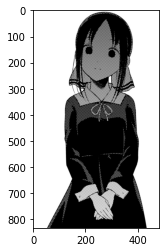

In [21]:
#esperimenti da https://matplotlib.org/tutorials/introductory/images.html

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread(nomeImmagine(1))
plt.imshow(img)

In [0]:
from PIL import Image
import numpy as np
image = Image.open('kaguya.png')
# convert image to numpy array
data = np.asarray(image)
data = np.resize(data, (image_size, image_size, 3))
data = np.expand_dims(data, axis=0)

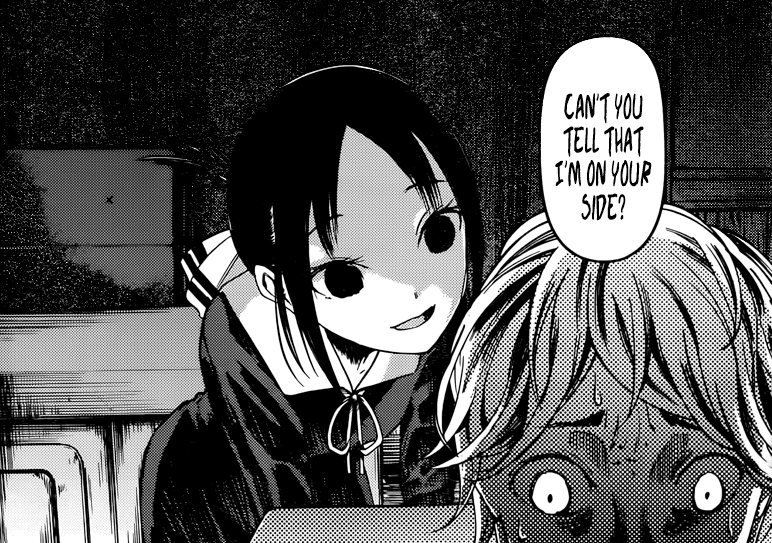

In [62]:
image

In [63]:
data.shape

(1, 224, 224, 3)

In [0]:
x = model.predict(data)

In [65]:
x

array([[0.]], dtype=float32)